# 风险函数hazard function

关于风险函数的定义，取决于它的使用背景。

从生存分析的角度推导，它指的是截止t或者大于t时刻，在t时刻的事件发生率。 通俗的讲就是一个导数，采用lambda或者h表示。
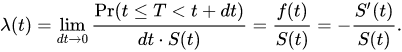

风险函数和生存函数可以相互推导,lifeline给出了最完整的解释。

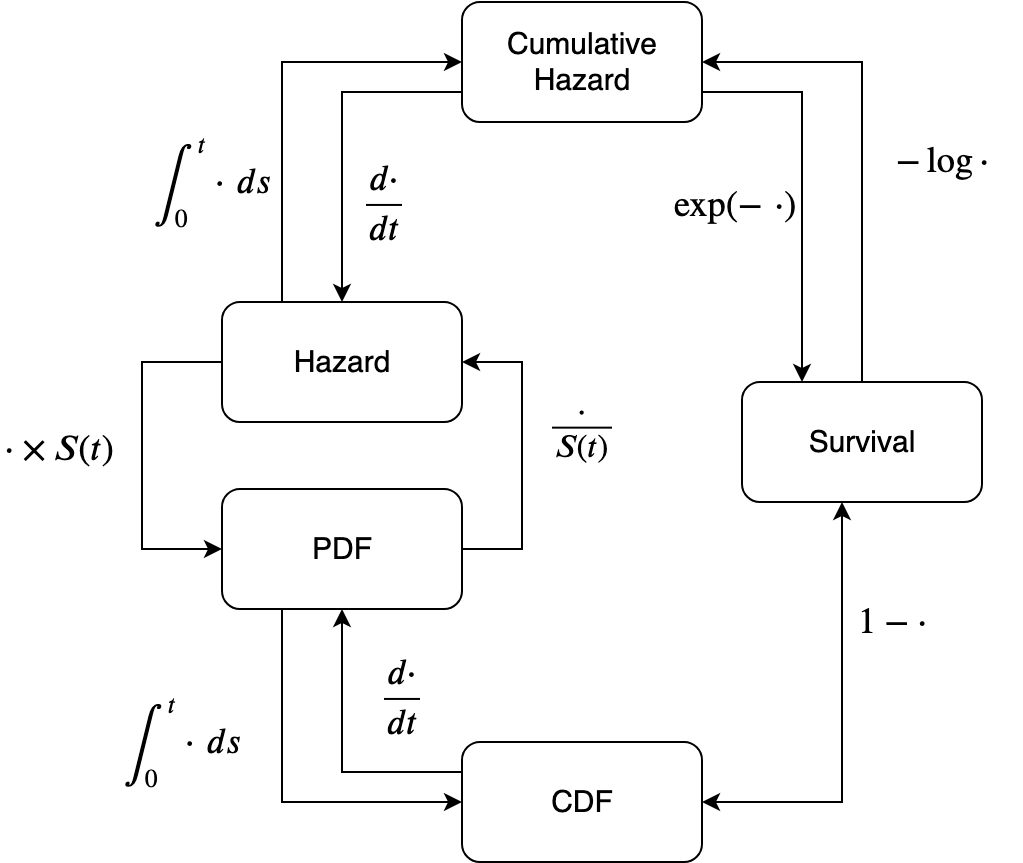

## 比例风险回归模型（proportional hazards model
今天我们要介绍的另一个模型，它就是比例风险回归模型（proportional hazards model）。 

它同样支持的协变量，因为名字中的比例就是指的协变量对风险的对数影响是线性的（比例）。

相比于baseline的风险模型，比例风险回归模型添加了一个比例项：


***注意这个比例项应该不随时间变化。***


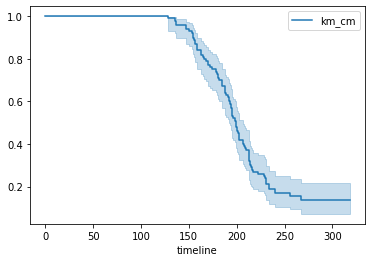

In [32]:
import pandas as pd
# read training data 
train_df = pd.read_csv('../data/PM_train.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['observed'] = (train_df['cycle'] >= train_df['max'])

import lifelines
from matplotlib import pyplot as plt
max_event = train_df.groupby('id').last()
max_event_censor_1 = train_df[train_df['max']<=250].groupby('id').last()  
max_event_censor_2 = train_df[(train_df['max']>250) & (train_df['cycle']>250)].groupby('id').sample(n=1,random_state=21)

max_event_censor_mix = pd.concat([max_event_censor_1,max_event_censor_2])
kmf_cm = lifelines.KaplanMeierFitter(label='km_cm')
kmf_cm.fit(durations=max_event_censor_mix['cycle'],
event_observed=max_event_censor_mix['observed'])
kmf_cm.plot_survival_function()
plt.show()

In [33]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df=max_event_censor_mix[['s11','s12','cycle','observed']],duration_col='cycle',
event_col='observed',show_progress=True)
cph.summary

Iteration 1: norm_delta = 0.43702, step_size = 0.9000, log_lik = -334.74516, newton_decrement = 14.11514, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.18684, step_size = 0.9000, log_lik = -319.37170, newton_decrement = 1.59358, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.04197, step_size = 0.9000, log_lik = -317.71099, newton_decrement = 0.06718, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00108, step_size = 1.0000, log_lik = -317.64270, newton_decrement = 0.00004, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -317.64265, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
s11,2.833653,17.007475,0.833461,1.200099,4.467207,3.320445,87.113093,3.399861,0.000674,10.534534
s12,-0.898161,0.407318,0.272465,-1.432183,-0.364139,0.238787,0.694795,-3.296424,0.000979,9.996050


关于解释的重要说明：

假设coef为正，则因子exp(coef)大于 1，说明风险系数增加。

相反的，coef为负时，风险系数降低（小于1）。

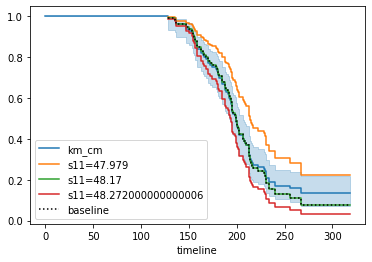

In [34]:
ax = kmf_cm.plot_survival_function()
cph.plot_partial_effects_on_outcome(['s11'], values=max_event_censor_mix[['s11']].quantile([0.1, 0.5,0.8]).values,ax=ax)
plt.show()

图中的baseline就是该协变量的均值所在的位置。

<AxesSubplot:>

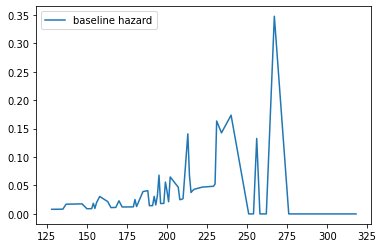

In [35]:
cph.baseline_hazard_.plot()

## 模型预测

和AFT模型类似，这里只需要给出协变量的数值，就可以预测生存函数。

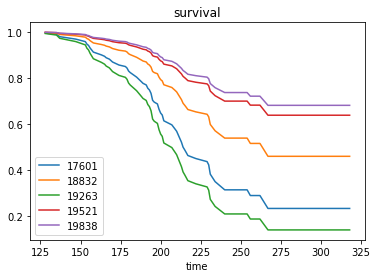

In [36]:
result= cph.predict_survival_function(max_event_censor_mix[['s11','s12']].iloc[-5:,:])
result.plot()
plt.xlabel('time')
plt.title('survival')
plt.show()

其实，Lifeline还提供很好的conditional_after参数，用于预测当下的情况。比如研究对象已经生存了65次了，后续的生存曲线是怎样的？

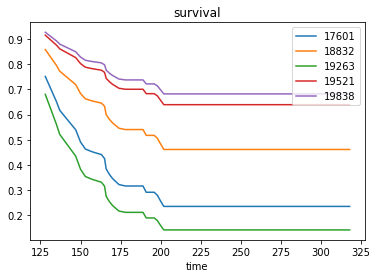

In [37]:
result= cph.predict_survival_function(max_event_censor_mix[['s11','s12']].iloc[-5:,:],conditional_after=[65]*5 )
result.plot()
plt.xlabel('time')
plt.title('survival')
plt.show()

## 检查模型的假设条件
对COX PH模型来说，需要保证协变量的对风险的影响是时不变的。但是通常我们可以不需要进行模型的假设验证。（lifeline）
因为：
- 我们的目标是生存预测，只要能达到这个目的即可
- 再大的数据集也会有违反假设的情况，所以不要过虑
- 最经典的回答： Better an approximate answer to the exact question, rather than an exact answer to the approximate question.
我们宁愿获得一个准确问题的近似答案，不要获得一个近似问题的准确答案。

In [38]:
cph.check_assumptions(training_df =max_event_censor_mix[['s11','s12','cycle','observed']],p_value_threshold=0.1)

Proportional hazard assumption looks okay.


c:\users\renb\pycharmprojects\survival_analysis\env\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


[]